In [1]:
from tqdm import tqdm
import pandas as pd
from tabulate import tabulate
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib

d:\PrivateProjects\WroclawWeatherPredictor\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

In [3]:
TEST_SIZE = 0.2
VAL_SIZE = 0.2
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.01
SEQ_LENGTH = 24
DATA = './data/meteo_16.9_51.103333_2025-11-30_2015-12-31.csv' 

TARGET_FET = 'apparent_temperature'
DROP_FEATURES = ['date', 'hour', 'dayofyear']

MODEL_NAME = 'model_v3_LSTM'
SAVE_PATH = './models'

In [4]:
df = pd.read_csv(DATA)
df['date'] = pd.to_datetime(df['date'])

df["hour"] = df["date"].dt.hour
df["dayofyear"] = df["date"].dt.dayofyear

df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["dayofyear_sin"] = np.sin(2 * np.pi * df["dayofyear"] / 365)
df["dayofyear_cos"] = np.cos(2 * np.pi * df["dayofyear"] / 365)

print(tabulate(df.head(), headers='keys', tablefmt='psql'))

+----+---------------------------+------------------+------------------------+------------------------+--------------------+----------------------+------------------+-----------------------------+--------------------------+--------+----------------+------------+--------------+---------------+--------+-------------+------------+------------+-----------------+-----------------+
|    | date                      |   temperature_2m |   relative_humidity_2m |   apparent_temperature |   surface_pressure |   wind_direction_10m |   wind_speed_10m |   soil_temperature_0_to_7cm |   soil_moisture_0_to_7cm |   rain |   dew_point_2m |   snowfall |   snow_depth |   cloud_cover |   hour |   dayofyear |   hour_sin |   hour_cos |   dayofyear_sin |   dayofyear_cos |
|----+---------------------------+------------------+------------------------+------------------------+--------------------+----------------------+------------------+-----------------------------+--------------------------+--------+----------

In [5]:
df_len = len(df)

train_end = int(df_len * (1 - TEST_SIZE - VAL_SIZE))
val_end = int(df_len * (1 - TEST_SIZE))

train_df = df.iloc[:train_end].copy()
val_df = df.iloc[train_end:val_end].copy()
test_df = df.iloc[val_end:].copy()

print(f'Train size: {len(train_df)}')
print(f'Validation size: {len(val_df)}')
print(f'Test size: {len(test_df)}')

Train size: 52156
Validation size: 17386
Test size: 17386


In [6]:
def split_Xy(dataset):
    X = dataset.drop(columns=DROP_FEATURES + [TARGET_FET])
    y = dataset[TARGET_FET]
    return X, y

X_train, y_train = split_Xy(train_df)
X_val, y_val = split_Xy(val_df)
X_test, y_test = split_Xy(test_df)


scaler_X = StandardScaler()
scaler_y = StandardScaler()

scaler_X.fit(X_train)
scaler_y.fit(y_train.values.reshape(-1, 1))

X_train_scaled = scaler_X.transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

print(pd.DataFrame(X_train_scaled).describe())
print(pd.DataFrame(y_train_scaled).describe())

                 0             1             2             3             4   \
count  5.215600e+04  5.215600e+04  5.215600e+04  5.215600e+04  5.215600e+04   
mean   8.718984e-18 -2.702885e-16  9.874250e-16 -9.372908e-17  3.029847e-16   
std    1.000010e+00  1.000010e+00  1.000010e+00  1.000010e+00  1.000010e+00   
min   -3.349971e+00 -3.168118e+00 -3.882873e+00 -2.406644e+00 -1.946369e+00   
25%   -7.756560e-01 -6.955416e-01 -5.916056e-01 -7.790038e-01 -7.332933e-01   
50%   -4.182818e-02  1.626081e-01  3.009640e-02  1.733288e-01 -2.013036e-01   
75%    7.766858e-01  8.399834e-01  6.449983e-01  8.368086e-01  5.562057e-01   
max    2.988171e+00  1.613499e+00  3.515388e+00  1.652201e+00  6.643088e+00   

                 5             6             7             8             9   \
count  5.215600e+04  5.215600e+04  5.215600e+04  5.215600e+04  5.215600e+04   
mean  -1.656607e-16  3.661973e-16 -4.904429e-17  2.615695e-17 -1.961771e-17   
std    1.000010e+00  1.000010e+00  1.000010e+00  1.

In [7]:
def create_seq(scaled_X, scaled_y, seq_length):
    sequences = []
    targets = []
    
    for i in tqdm(range(len(scaled_X) - seq_length)):
        seq_X = scaled_X[i:i+seq_length]
        seq_y = scaled_y[i+seq_length]
        sequences.append(seq_X)
        targets.append(seq_y)
    return np.array(sequences), np.array(targets)

X_train_seq, y_train_seq = create_seq(X_train_scaled, y_train_scaled, SEQ_LENGTH)
X_val_seq, y_val_seq = create_seq(X_val_scaled, y_val_scaled, SEQ_LENGTH)
X_test_seq, y_test_seq = create_seq(X_test_scaled, y_test_scaled, SEQ_LENGTH)
print()
print(f'Train sequences: {X_train_seq.shape}, Train targets: {y_train_seq.shape}')
print(f'Validation sequences: {X_val_seq.shape}, Validation targets: {y_val_seq.shape}')
print(f'Test sequences: {X_test_seq.shape}, Test targets: {y_test_seq.shape}')

100%|██████████| 17362/17362 [00:00<00:00, 1735705.07it/s]


Train sequences: (52132, 24, 16), Train targets: (52132,)
Validation sequences: (17362, 24, 16), Validation targets: (17362,)
Test sequences: (17362, 24, 16), Test targets: (17362,)


In [8]:
model = tf.keras.Sequential(name=MODEL_NAME)
model.add(tf.keras.layers.InputLayer(shape=(SEQ_LENGTH, X_train_seq.shape[2])))
model.add(tf.keras.layers.LSTM(128, return_sequences=True, activation='tanh'))
model.add(tf.keras.layers.LSTM(64, activation='tanh'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
    loss=tf.keras.losses.Huber(), 
    metrics=['mae'])

print(model.summary())

Model: "model_v3_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,873 (499.50 KB)

 Trainable params: 127,873 (499.50 KB)

 Non-trainable params: 0 (0.00 B)

None


In [9]:
monitors = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.10, patience=3, min_lr=1e-6, verbose=1)
]
history = model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=monitors)

Epoch 1/100
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - loss: 0.0069 - mae: 0.0796 - val_loss: 0.0048 - val_mae: 0.0740 - learning_rate: 0.0100
Epoch 2/100
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - loss: 0.0036 - mae: 0.0622 - val_loss: 0.0033 - val_mae: 0.0588 - learning_rate: 0.0100
Epoch 3/100
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - loss: 0.0032 - mae: 0.0590 - val_loss: 0.0033 - val_mae: 0.0585 - learning_rate: 0.0100
Epoch 4/100
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - loss: 0.0030 - mae: 0.0573 - val_loss: 0.0037 - val_mae: 0.0631 - learning_rate: 0.0100
Epoch 5/100
1627/1630 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0029 - mae: 0.0559
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 30s 18ms/step - loss: 0.0028 - mae: 0.0552 - val_loss: 0.0036 - val_mae: 0.0627 - learning_rate: 0.0100
Epoch 6/100
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 30s 18ms/step - loss: 0.0019 - mae: 0.0438 - val_loss: 0.0024 - val_mae: 

In [10]:
os.makedirs(os.path.join(SAVE_PATH, MODEL_NAME), exist_ok=True)
model.save(os.path.join(SAVE_PATH, MODEL_NAME, 'model.keras'))
joblib.dump(scaler_X, os.path.join(SAVE_PATH, MODEL_NAME, 'scaler_X.pkl'))
joblib.dump(scaler_y, os.path.join(SAVE_PATH, MODEL_NAME, 'scaler_y.pkl'))

['./models\\model_v3_LSTM\\scaler_y.pkl']

=== TRAINING ===


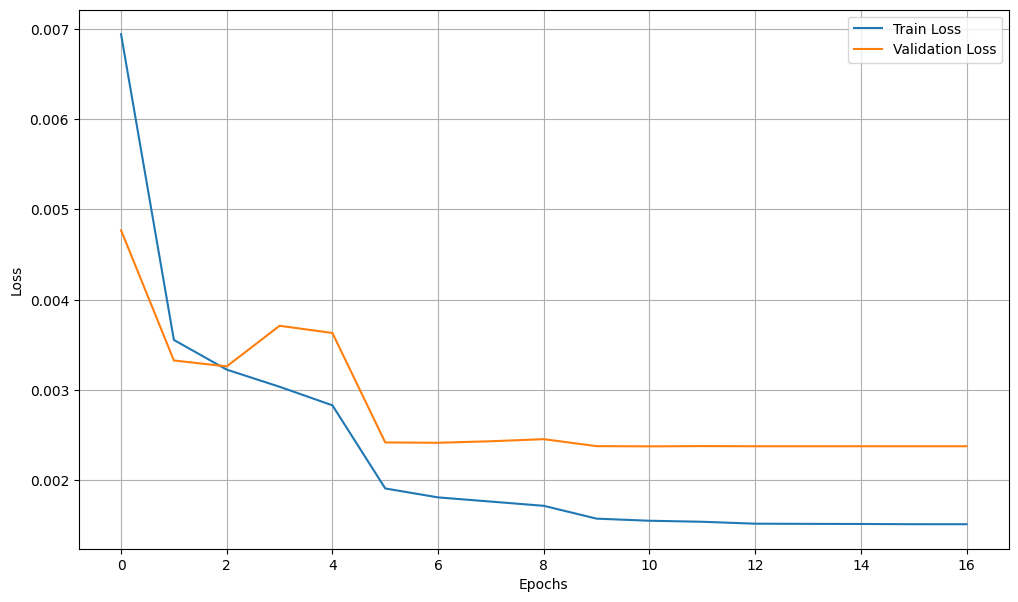

In [11]:
print("=== TRAINING ===")
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()
    

In [12]:
mae_scaled = model.evaluate(X_test_seq, y_test_seq, verbose=0)[1]

pred_scaled = model.predict(X_test_seq).flatten()
pred_rescaled = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
test_y_rescaled = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

print()
print("=== TEST ===")

mae = np.mean(np.abs(pred_rescaled - test_y_rescaled))
print(f'Test MAE on scaled data: {mae_scaled:.3f}')
print(f'Test MAE rescaled to original values: {mae:.3f}')

print()

comp_tab = pd.DataFrame({
    'Data': test_df['date'].iloc[SEQ_LENGTH:SEQ_LENGTH + len(test_y_rescaled)].reset_index(drop=True),
    'Actual': test_y_rescaled,
    'Predicted': pred_rescaled
})
comp_tab = comp_tab.sort_values(by='Data')

print(tabulate(comp_tab, headers='keys', tablefmt='psql'))

543/543 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step

=== TEST ===
Test MAE on scaled data: 0.046
Test MAE rescaled to original values: 0.464

+-------+---------------------------+--------------+--------------+
|       | Data                      |       Actual |    Predicted |
|-------+---------------------------+--------------+--------------|
|     0 | 2023-12-08 13:00:00+00:00 |  -5.40536    |  -6.46208    |
|     1 | 2023-12-08 14:00:00+00:00 |  -5.63868    |  -5.14946    |
|     2 | 2023-12-08 15:00:00+00:00 |  -6.67264    |  -6.01606    |
|     3 | 2023-12-08 16:00:00+00:00 |  -7.34328    |  -7.14668    |
|     4 | 2023-12-08 17:00:00+00:00 |  -7.7448     |  -7.49647    |
|     5 | 2023-12-08 18:00:00+00:00 |  -7.21717    |  -7.70223    |
|     6 | 2023-12-08 19:00:00+00:00 |  -6.85504    |  -6.67164    |
|     7 | 2023-12-08 20:00:00+00:00 |  -6.24541    |  -6.00837    |
|     8 | 2023-12-08 21:00:00+00:00 |  -5.32335    |  -5.41639    |
|     9 | 2023-12-08 22:00:00+00:00 |  -4.16021    | 

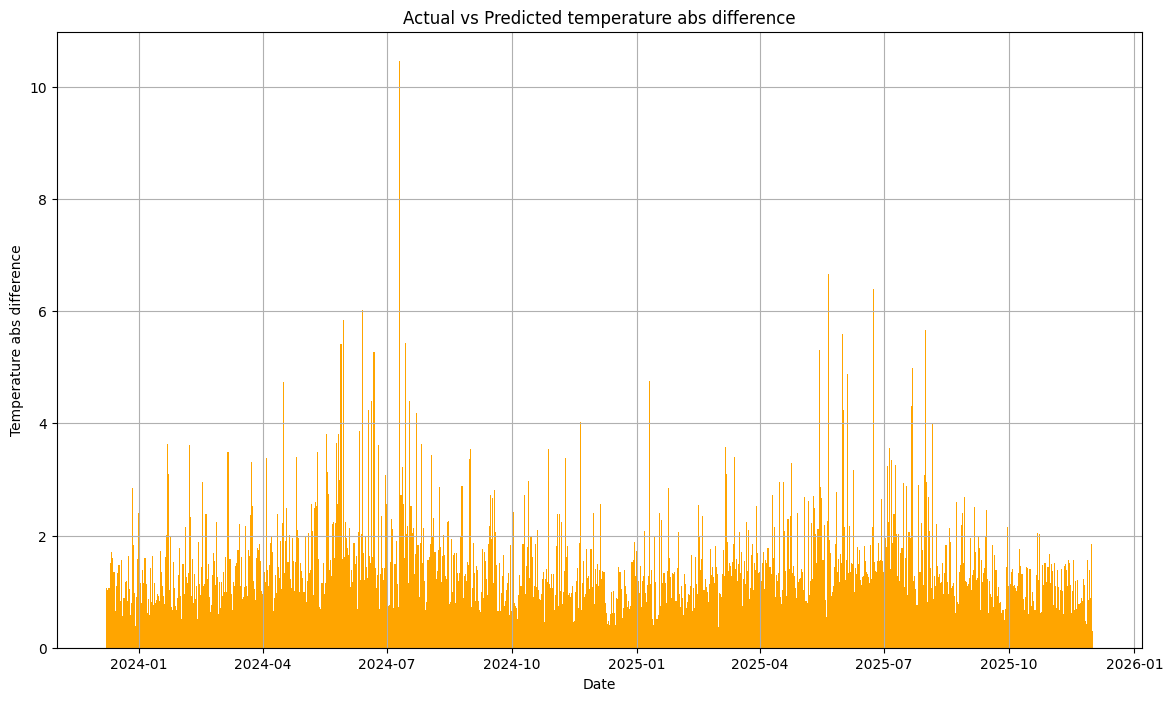

In [13]:
plt.figure(figsize=(14, 8))
diff = np.abs(comp_tab['Actual'] - comp_tab['Predicted'])
plt.bar(comp_tab['Data'], diff, color='orange')
plt.xlabel('Date')
plt.ylabel('Temperature abs difference')
plt.title('Actual vs Predicted temperature abs difference')
plt.grid()
plt.show()

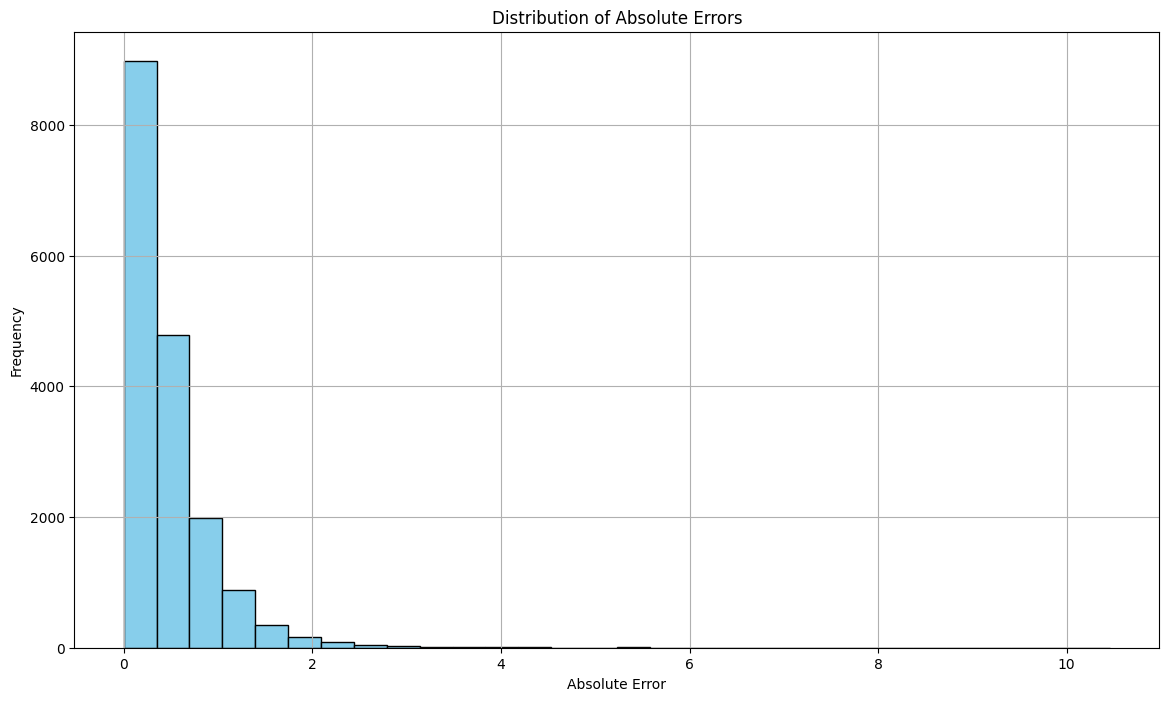

In [14]:
plt.figure(figsize=(14, 8))
plt.hist(diff, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.title('Distribution of Absolute Errors')
plt.grid()
plt.show()